In the business landscape, loyalty is the number one priority. However, unforseeable circumstances lead to some customers leaving the platform and may have jumped ship to a competitor. Customer churn is defined as the rate at which a business loses customers. From the business owner's POV, finding ways to keep its customer base can be a tall order. In this notebook, we will attempt to gain insights and perform modeling on a telco churning database.

# PART 1: DATA CLEANING

## First things first, import the necessary libraries

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

seed = 1001

## Load the dataset
The dataset is sourced from [1](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data). It has around 7000 entries and has 21 columns.

In [9]:
data = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [10]:
print(data.shape)

(7043, 21)


Let us take a look at the unique values per column and if there are null values.

In [11]:
data_info = pd.DataFrame(data.dtypes, columns=['Dtype'])
data_info['Unique'] = data.nunique().values
data_info['Null'] = data.isnull().sum().values
data_info

,Dtype,Unique,Null
customerID,object,7043,0
gender,object,2,0
SeniorCitizen,int64,2,0
Partner,object,2,0
Dependents,object,2,0
tenure,int64,73,0
PhoneService,object,2,0
MultipleLines,object,3,0
InternetService,object,3,0
OnlineSecurity,object,3,0


- The table reveals that there are apparently no null values. 
- Majority of the columns are categorical.
- In this analysis, we can safely remove the `customerID` column because it primarily contains unique values.
- Note that `TotalCharges` is supposed to be numerical, but it isn't. Let us investigate.

In [12]:
# drop customerID
data.drop('customerID', axis=1, inplace=True)

In [13]:
# check unique elements in TotalCharges
data['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

Since all entries in `TotalCharges` are string, we can use pandas' `to_numeric` function.

In [14]:
# convert TotalCharges to numeric, all non-numeric will be converted to NaN
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

Upon rechecking the dataframe `data` for null values...

In [15]:
data.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Taking a close look at those containing null values...

In [16]:
data[data.isna().any(axis=1)]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


...we see that we can safely drop these rows.

In [17]:
data.dropna(inplace=True)

Let's take a look at the unique elements per column.

In [18]:
for i in data.columns:
    print(f'Unique elements in {i}: {data[i].unique()}')

Unique elements in gender: ['Female' 'Male']
Unique elements in SeniorCitizen: [0 1]
Unique elements in Partner: ['Yes' 'No']
Unique elements in Dependents: ['No' 'Yes']
Unique elements in tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
Unique elements in PhoneService: ['No' 'Yes']
Unique elements in MultipleLines: ['No phone service' 'No' 'Yes']
Unique elements in InternetService: ['DSL' 'Fiber optic' 'No']
Unique elements in OnlineSecurity: ['No' 'Yes' 'No internet service']
Unique elements in OnlineBackup: ['Yes' 'No' 'No internet service']
Unique elements in DeviceProtection: ['No' 'Yes' 'No internet service']
Unique elements in TechSupport: ['No' 'Yes' 'No internet service']
Unique elements in StreamingTV: ['No' 'Yes' 'No internet service']
Unique elements in StreamingMovies: ['No' 'Yes' 'No internet ser

This time, we convert `SeniorCitizen` column into a Yes-No one using pandas' `map`.

In [19]:
data['SeniorCitizen'] = data['SeniorCitizen'].map({0: 'No', 1: 'Yes'})


# upon checking...
data['SeniorCitizen'].unique()

array(['No', 'Yes'], dtype=object)

## Services availed
We can define a variable `SvcAvailed` that sums the number of services the customer has either availed or has subscribed to. In the same manner, we also define the variable `SvcDuration` (in months) as the quotient of the total charges `TotalCharges` over `MonthlyCharges`.

In [20]:
svcList = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity' , 'OnlineBackup', 'StreamingMovies', 'PaperlessBilling' ,'TechSupport', 'StreamingTV', 'DeviceProtection']

svcDat = data.copy()

svcDat[svcList] = svcDat[svcList].replace({'No':0, 'Yes':1,'No phone service': 0,'Fiber optic': 1, 'DSL': 1,'No internet service': 0})

# define 'SvcAvailed' and 'SvcDuration'
data['SvcAvailed'] = svcDat[svcList].sum(axis=1)
data['SvcDuration'] = data['TotalCharges'] / data['MonthlyCharges'] 
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SvcAvailed,SvcDuration
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,3,1.000000
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,4,33.178227
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,5,2.008357
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,4,43.516548
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,3,2.144979


# PART 2: EXPLORATORY DATA ANALYSIS

Now, it's time to probe the dataset and see if insights can be extracted. 

First, we plot a histogram of `SvcAvailed` against `Churn`.

In [21]:
fig = px.histogram(data_frame=data, x="SvcAvailed", color="Churn", barmode="group", width=800)
fig.show()

Next question: does tenure and length of service availment affect churning? 

In [22]:
fig = px.box(data_frame=data, x="gender", y="SvcDuration", color="Churn", width=900)
fig.show()

From the box plot above, customers that tend to keep services like internet and phone lines are highly likely to stay regardless of gender. 

In [23]:
fig = px.box(data_frame=data, x="gender", y="tenure", color="Churn", width=900)
fig.show()

The same holds true for `tenure`.

Let's take a good look on churn proportion against select variables.

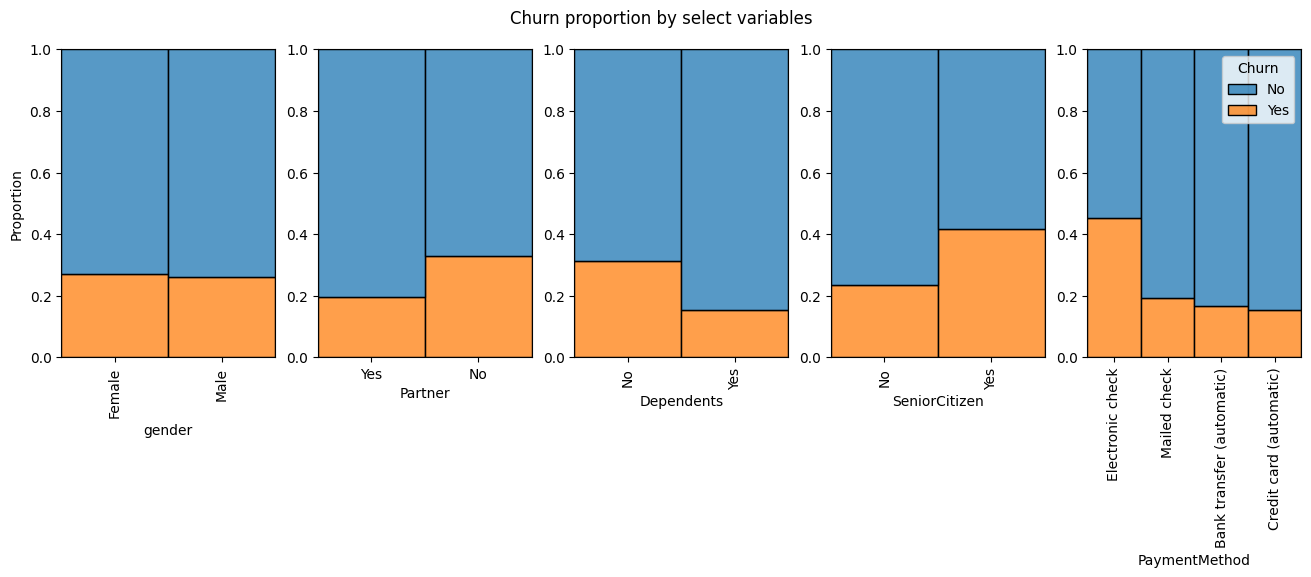

In [24]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(16, 4))
sns.histplot(data, x="gender", hue="Churn", multiple="fill", bins=6, ax=ax0, legend=False)
sns.histplot(data, x="Partner", hue="Churn", multiple="fill", ax=ax1, legend=False)
sns.histplot(data, x="Dependents", hue="Churn", multiple="fill", ax=ax2, legend=False)
sns.histplot(data, x="SeniorCitizen", hue="Churn", multiple="fill", ax=ax3, legend=False)
sns.histplot(data, x="PaymentMethod", hue="Churn", multiple="fill", ax=ax4)
ax0.set_xticklabels(ax0.get_xticklabels(), rotation= 90)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation= 90)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation= 90)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation= 90)
ax0.set_ylabel('Proportion')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
fig.suptitle("Churn proportion by select variables")
plt.show()

From the plots above, we see that:
- based on the churn proportion, gender doesn't affect the client's decision.
- clients who have partners and dependents are less likely to churn.
- age affects the client's decision, as elderlies tend to churn more than those who are younger.
- clients doing transactions via mailed check as well as automatic bank transfer and credit card transactions tend to churn less.

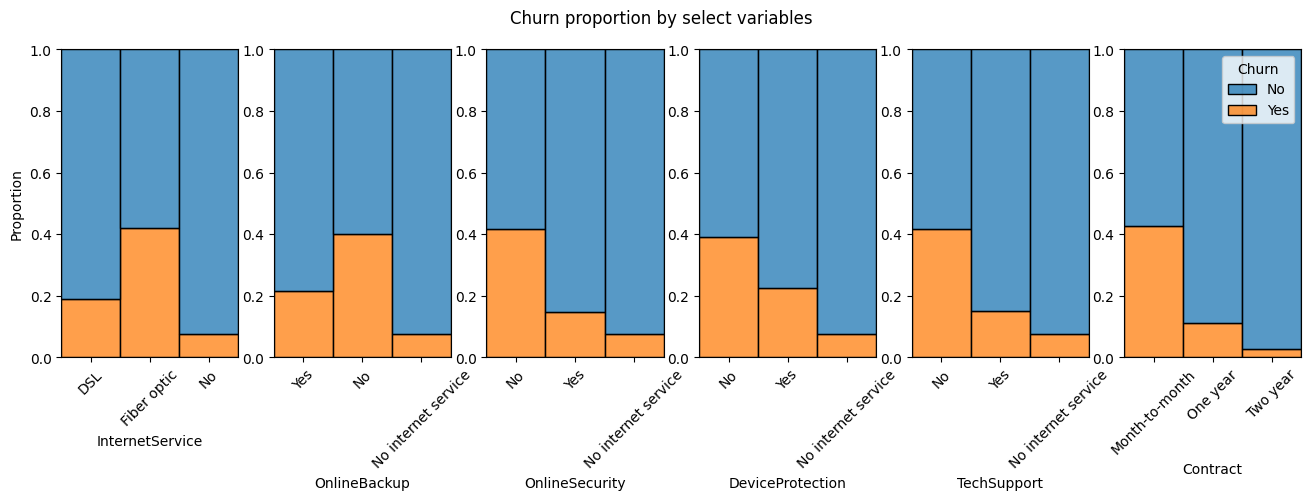

In [25]:
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6, figsize=(16, 4))
sns.histplot(data, x="InternetService", hue="Churn", multiple="fill", bins=6, ax=ax0, legend=False)
sns.histplot(data, x="OnlineBackup", hue="Churn", multiple="fill", ax=ax1, legend=False)
sns.histplot(data, x="OnlineSecurity", hue="Churn", multiple="fill", ax=ax2, legend=False)
sns.histplot(data, x="DeviceProtection", hue="Churn", multiple="fill", ax=ax3, legend=False)
sns.histplot(data, x="TechSupport", hue="Churn", multiple="fill", ax=ax4, legend=False)
sns.histplot(data, x="Contract", hue="Churn", multiple="fill", ax=ax5)
ax0.set_xticklabels(ax0.get_xticklabels(), rotation= 45)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation= 45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation= 45)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation= 45)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation= 45)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation= 45)
ax0.set_ylabel('Proportion')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
fig.suptitle("Churn proportion by select variables")
plt.show()

Furthermore:
- clients having fiber optic connections tend to churn more than those having DSL connections and those having no internet service providers. 
- customers that have availed of protection systems tend to stay more than those who don't.
- clients who don't have technical support are more likely to refuse than those who do.
- customers on short-term contracts tend to leave more than those who are on annual, long-term contracts.

# PART 3: MODELING

## Label Encoder
Since majority of the columns are categorical, we need to transform them through label encoding.

In [26]:
data_model = data.copy()
data_model.drop(['tenure', 'MonthlyCharges', 'TotalCharges', 'SvcAvailed', 'SvcDuration'], axis=1,inplace=True)

scaler = LabelEncoder()
data_model = data_model.apply(lambda x: scaler.fit_transform(x))

data_model[['tenure', 'MonthlyCharges', 'TotalCharges', 'SvcAvailed', 'SvcDuration']] = data[['tenure', 'MonthlyCharges', 'TotalCharges', 'SvcAvailed', 'SvcDuration']]
data_model.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure,MonthlyCharges,TotalCharges,SvcAvailed,SvcDuration
0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0,1,29.85,29.85,3,1.000000
1,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0,34,56.95,1889.50,4,33.178227
2,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1,2,53.85,108.15,5,2.008357
3,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0,45,42.30,1840.75,4,43.516548
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1,2,70.70,151.65,3,2.144979


Now, the dataset is ready for modeling 💃! But first, let's see if any of these variables are correlated.

## Correlation

In [27]:
# Calculate the correlation matrix  
corr_matrix = data_model.corr()

# This is to generate text for annotations BUT hide it by setting it to an array of empty strings
text = [['' for _ in range(len(corr_matrix.columns))] for _ in range(len(corr_matrix.index))]


# Create the heatmap
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    annotation_text=text,
    colorscale='RdBu',
    showscale=True
)

# Update the layout to add titles and adjust the size
fig.update_layout(
    xaxis=dict(tickangle=-45),
    yaxis=dict(tickmode='array', tickvals=list(range(len(corr_matrix.index))), ticktext=list(corr_matrix.index)),
    width=800, height=800
)

fig.show()

## ML models
For this notebook, we will perform a classification task (of whether a customer's gonna churn or not) using logistic regression, random forest classifier, and k-nearest neighbors (KNN) classifier. Furthermore, we will assess the performances of the models using a 5-fold cross-validation with accuracy as the scoring metric.

In [28]:
X = data_model.drop("Churn", axis=1)
y = data_model["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")

X_train: (5625, 21)
X_test: (1407, 21)


In [29]:
models = {
    "LR": LogisticRegression(random_state=seed, max_iter=10000),
    "KNN": KNeighborsClassifier(),
    "RF": RandomForestClassifier(random_state=seed)}

scoring = "accuracy"

scores = []
for name, model in models.items():
    cvScores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)
    print(f"{name} model -> average score = {np.mean(cvScores):.3f} ± {np.std(cvScores):.3f}")
    scores.append(cvScores)

LR model -> average score = 0.803 ± 0.008
KNN model -> average score = 0.764 ± 0.008
RF model -> average score = 0.797 ± 0.008


Based on the average CV scores of roughly 0.8, the models were shown to be fairly accurate despite not having undergone parameter optimization.

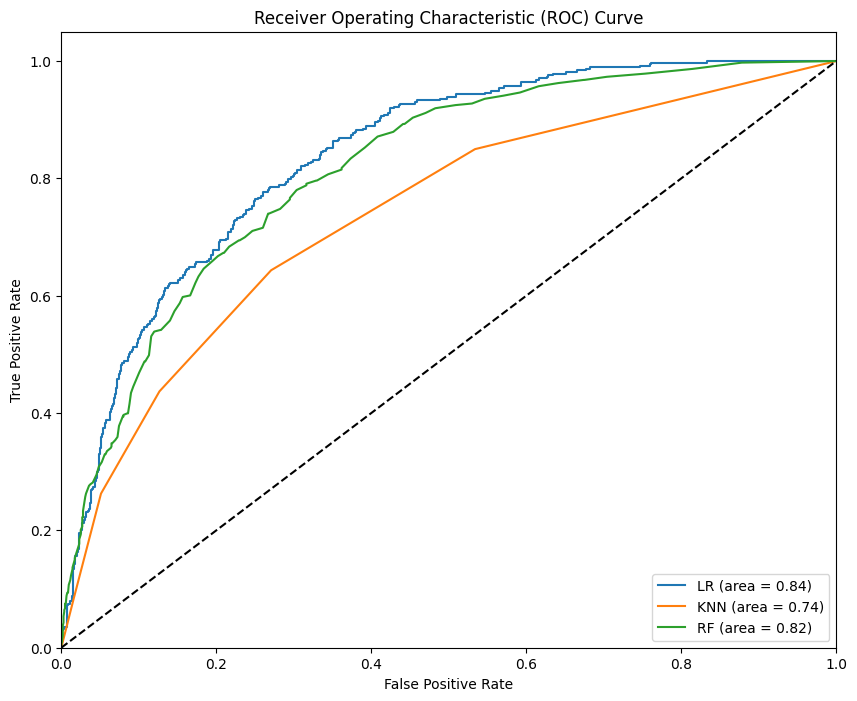

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve and AUC for each model
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The ideal area under the ROC curve is 1. Based on the areas calculated from the three models were satisfactory in predicting customer churning tendencies.